In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from numba import jit

In [11]:
k10=np.load("prueba_10k.npy")
k20=np.load("prueba_20k.npy")
k50=np.load("prueba_50k.npy")
k250=np.load("prueba_250k.npy")

In [12]:
ksi10k=np.genfromtxt('ksi10k.txt', delimiter=',')
ksi20k=np.genfromtxt('ksi20k.txt', delimiter=',')
ksi50k=np.genfromtxt('ksi50k.txt', delimiter=',')
ksils10k=np.genfromtxt('ksils10k.txt', delimiter=',')
ksils20k=np.genfromtxt('ksils20k.txt', delimiter=',')
ksils50k=np.genfromtxt('ksils50k.txt', delimiter=',')

In [13]:
@jit
def cubo(puntos,dim,lado):
    '''
    Genera puntos con coordenadas de la dimension que se indique dentro de un cubo de lado que se indique 
    puntos: Cantidad de puntos que se quieren generar
    lado: tamaño del lado del cubo
    dim: número de dimensiones del cubo
    '''
    return np.random.uniform(0,lado,size=(puntos,dim))

@jit
def dist(p1,p2):
    '''
    Calcula la distancia mediante el teorema de pitágoras entre el punto p1 y el punto p2.
    Acepta puntos cualquier dimensión.
    '''
    return np.sqrt(np.sum(np.square(p1-p2)))

@jit
def distpuntos(puntos,dist):
    '''
    Calcula todas las distancias entre el conjunto de puntos "puntos" con la función dist.
    La función dist debe ser compatible con el tipo de puntos.
    ''' 
    r=[]
    for i in range(len(puntos)):
        r.append(dist(puntos[i],puntos))
    return r


@jit
def ksi(puntos,dist,bins=50):
    '''
    Calcula la función ksi(r) de un conjunto de puntos dada una función de distancia dist.
    Las coordenadas de los puntos no pueden ser negativas, deben desplazarse hacia números positivos para
    servir en esta función.
    Por default divide en 50 intervalos el rango entre 0 y la máxima distancia en un cubo que encierre a todos
    los puntos.
    '''
    dim=len(puntos[0])
    l=np.max(puntos)
    puntosu=cubo(len(puntos),dim,l)

    maxdist=np.sqrt(dim*l**2)
    
    a=np.zeros(bins)
    b=np.zeros(bins)
    for i  in range(len(puntos)):
        for j in range(len(puntos)):
            if(i>j):
                a[int(np.floor(dist(puntos[i],puntos[j])/maxdist*bins))]+=1
                b[int(np.floor(dist(puntosu[i],puntosu[j])/maxdist*bins))]+=1

    centros=[maxdist/bins*(1+2*i)/2 for i in range(bins)]
    
    ksi=(a/b-1,centros)
    return ksi



@jit
def ksils(puntos,dist,bins=50):
    '''
    Calcula la función ksi(r) de Landy-Szalay de un conjunto de puntos dada una función de distancia "dist".
    Las coordenadas de los puntos no pueden ser negativas, deben desplazarse hacia números positivos para
    servir en esta función.
    Por default divide en 50 intervalos el rango entre 0 y la máxima distancia en un cubo que encierre a todos
    los puntos.
    '''
    dim=len(puntos[0])
    l=np.max(puntos)
    puntosu=cubo(len(puntos),dim,l)
    puntoscomb=np.append(puntos,puntosu,axis=0)
    maxdist=np.sqrt(dim*l**2)

    a=np.zeros(bins)
    b=np.zeros(bins)
    for i  in range(len(puntos)):
        for j in range(len(puntos)):
            if(i>j):
                a[int(np.floor(dist(puntos[i],puntos[j])/maxdist*bins))]+=1
                b[int(np.floor(dist(puntosu[i],puntosu[j])/maxdist*bins))]+=1

    c=np.zeros(bins)
    for i  in range(len(puntoscomb)):
        for j in range(len(puntoscomb)):
            if(i>j):
                c[int(np.floor(dist(puntoscomb[i],puntoscomb[j])/maxdist*bins))]+=1

    centros=[maxdist/bins*(1+2*i)/2 for i in range(bins)]

    nop=len(puntos)

    ksi=((1/(np.square(nop))*a+1/(np.square(nop))*b-2*1/(np.square(nop*2))*c)/(1/(np.square(nop))*b),centros)
    return ksi

In [42]:
start_time = time.time()
ksi10k=ksi(k10,dist,bins=250)
print("ksi10k: %s seconds" % (time.time() - start_time))

ksi10k: 20.11345863342285 seconds


In [ ]:
start_time = time.time()
ksi20k=ksi(k20,dist,bins=250)
print("ksi20k: %s seconds" % (time.time() - start_time))

In [ ]:
start_time = time.time()
ksi50k=ksi(k50,dist,bins=250)
print("ksi50k: %s seconds" % (time.ti{me() - start_time))

In [ ]:
start_time = time.time()
ksils10k=ksils(k10,dist,bins=250)
print("ksils10k: %s seconds" % (time.time() - start_time))

In [ ]:
start_time = time.time()
ksils20k=ksils(k20,dist,bins=250)
print("ksils20k: %s seconds" % (time.time() - start_time))

In [ ]:
start_time = time.time()
ksils50k=ksils(k50,dist,bins=250)
print("ksi1: %s seconds" % (time.time() - start_time))

In [6]:
def graf(KSI,nombre,recorte=[0,250]):
    fig, ax = plt.subplots(4,figsize=[8,10])
    ax=plt.subplot(2, 1, 1)
    ax.plot(KSI[1][recorte[0]+5:recorte[1]],KSI[0][recorte[0]+5:recorte[1]],"r")
    ax.set_ylabel(r'$\xi (r)$')
    ax.set_xlabel(r'$r$')
    ax.set_title('Correlación'+nombre[0]+' en función de la distancia '+nombre[1])

    ax=plt.subplot(2, 1, 2)
    ax.plot(KSI[1][recorte[0]:recorte[1]],KSI[0][recorte[0]:recorte[1]]*np.square(KSI[1][recorte[0]:recorte[1]]),"b")
    ax.set_ylabel(r'$\xi (r) \cdot r^2$')
    ax.set_xlabel(r'$r$')
    ax.set_title('Correlación'+nombre[0]+' por distancia al cuadrado '+nombre[1])

In [7]:
def compactbins(KSI,div):
    new=np.zeros((2,int(len(KSI[0])/div)))
    for i in range(int(len(KSI[0])/div)):
        for j in range(div):
            new[0][i]+=KSI[0][i*div+j]
            new[1][i]+=KSI[1][i*div+j]

    new[1]=new[1]/div
    return new

Text(0.5, 0, 'x')

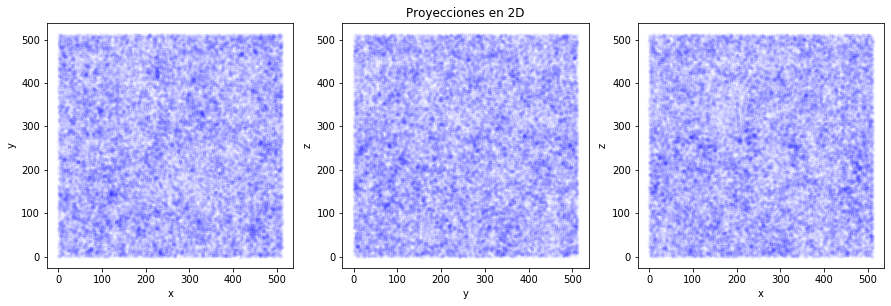

In [27]:
#Proyecciones en 2D
fig, ax = plt.subplots(10,figsize=[15,4.5])
ax=plt.subplot(1, 3, 1)
ax.plot(k50[:,0],k50[:,1],'b.', alpha=0.02)
ax.set_ylabel('y')
ax.set_xlabel('x')

ax=plt.subplot(1, 3, 2)
ax.plot(k50[:,1],k50[:,2],'b.', alpha=0.02)
ax.set_ylabel('z')
ax.set_xlabel('y')
ax.set_title('Proyecciones en 2D')

ax=plt.subplot(1, 3, 3)
ax.plot(k50[:,0],k50[:,2],'b.', alpha=0.02)
ax.set_ylabel('z')
ax.set_xlabel('x')

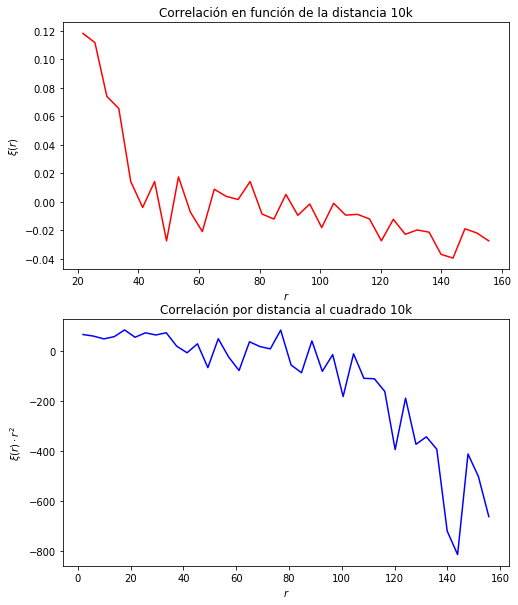

In [9]:
graf(compactbins(ksi10k,2),["","10k"],recorte=[0,40])

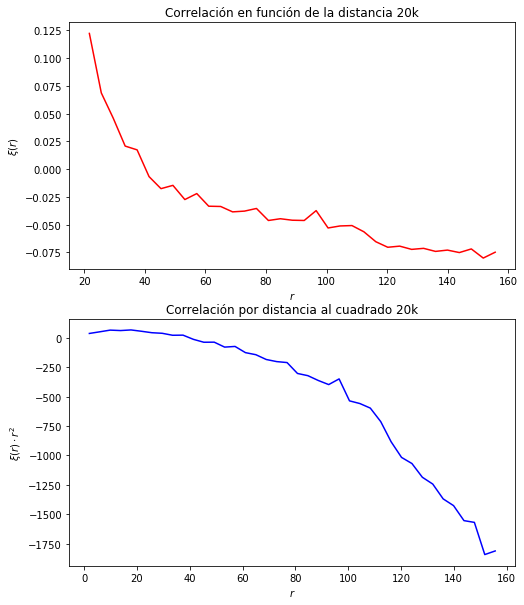

In [38]:
graf(compactbins(ksi20k,2),["","20k"],recorte=[0,40])

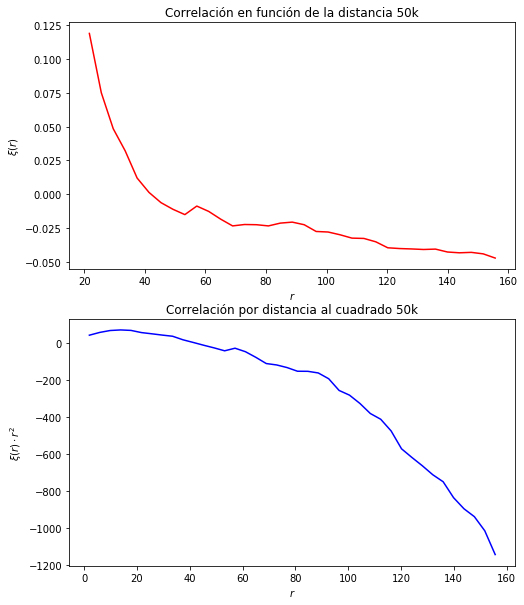

In [39]:
graf(compactbins(ksi50k,2),["","50k"],recorte=[0,40])

C:\Users\tu_rk\miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


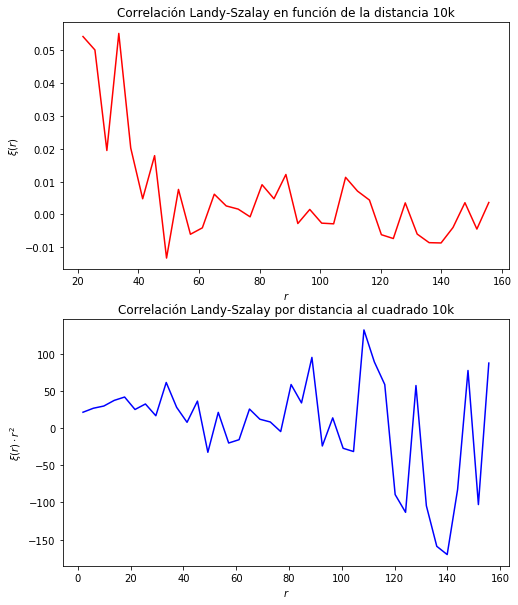

In [14]:
graf(compactbins(ksils10k,2),[" Landy-Szalay","10k"],recorte=[0,40])

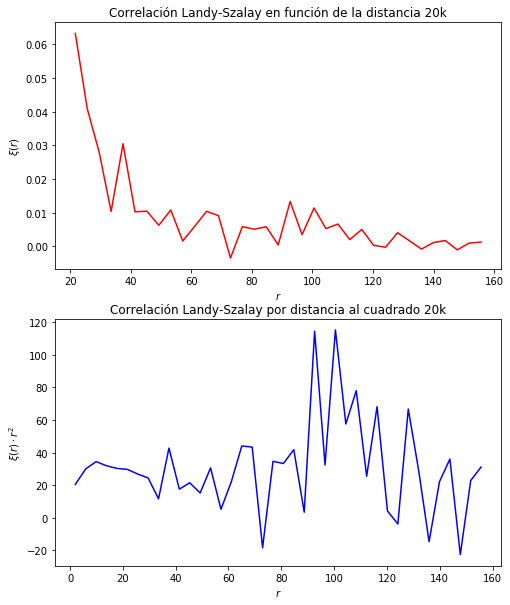

In [15]:
graf(compactbins(ksils20k,2),[" Landy-Szalay","20k"],recorte=[0,40])

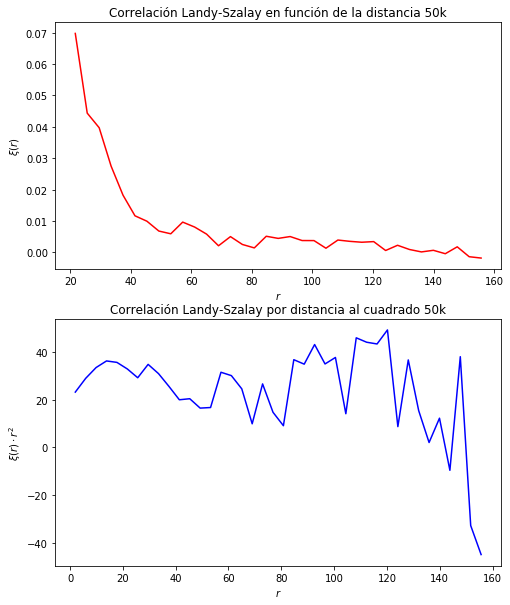

In [19]:
graf(compactbins(ksils50k,2),[" Landy-Szalay","50k"],recorte=[0,40])

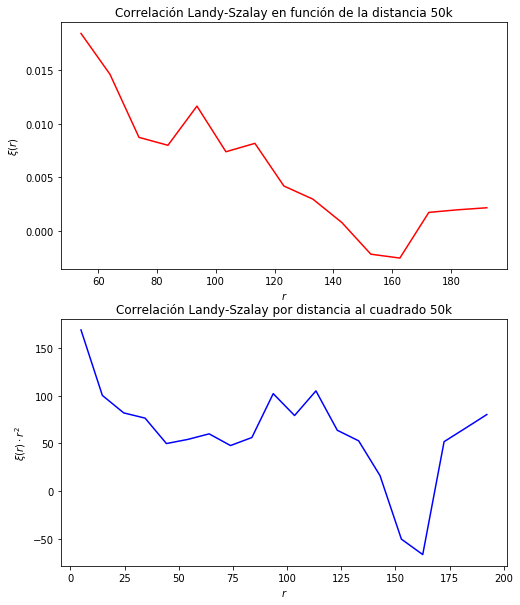

In [20]:
graf(compactbins(ksils50k,5),[" Landy-Szalay","50k"],recorte=[0,20])

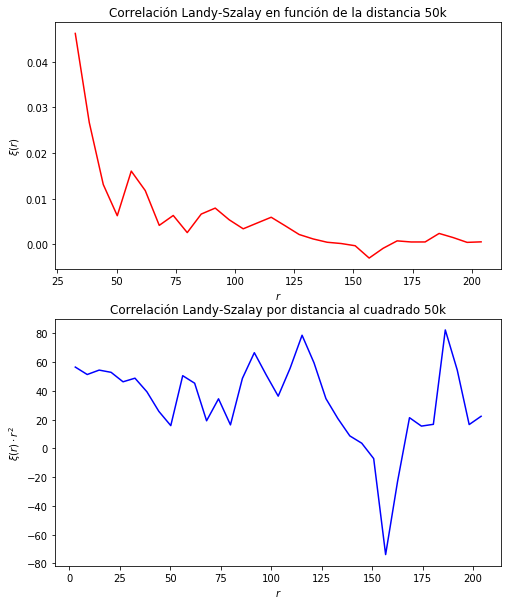

In [22]:
graf(compactbins(ksils50k,3),[" Landy-Szalay","50k"],recorte=[0,35])